In [1]:
import datetime
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import numpy as np
import numpy
import sklearn
import tslearn
import os
import tslearn.utils 
import seaborn
import pylab
from tslearn.clustering import TimeSeriesKMeans, KShape
import matplotlib.ticker as ticker
import pytz

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\tslearn\clustering\kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [2]:
def preprocessing(meter):
    meter_preprocessed = meter[["Time stamp", "Value"]].dropna(axis=0, how='any')
    meter_preprocessed["Value"] = meter_preprocessed["Value"].apply(lambda s: float(s.replace(",", "")))
    meter_preprocessed["Time stamp"] = pandas.to_datetime(meter_preprocessed["Time stamp"], format="%d/%m/%Y %I:%M:%S %p")
    meter_preprocessed = meter_preprocessed[meter_preprocessed["Value"] < 25]
    meter_preprocessed = meter_preprocessed[["Time stamp", "Value"]].dropna(axis=0, how='any')
    beg=meter_preprocessed["Time stamp"].min().replace(hour=23, minute=45, second=0)
    end = meter_preprocessed["Time stamp"].max().replace(hour=0, minute=0, second=0)
    helper = pandas.DataFrame({"Time stamp": pandas.date_range(beg, end, freq='15min')})
    meter_preprocessed = pandas.merge(meter_preprocessed, helper, on='Time stamp', how='outer').sort_values('Time stamp')    
    meter_preprocessed = pandas.merge(meter_preprocessed, helper, on='Time stamp', how='inner').sort_values('Time stamp')

    meter_preprocessed['Value'] = meter_preprocessed['Value'].interpolate(method='linear')
    meter_preprocessed = meter_preprocessed[meter_preprocessed["Time stamp"] > beg] 
    meter_preprocessed = meter_preprocessed[(meter_preprocessed["Time stamp"] < end)] 
    meter_preprocessed = meter_preprocessed.drop_duplicates(subset=["Time stamp"])
    return meter_preprocessed

In [3]:
n_clusters = 11
output_path = "./report_Library"
# Reading dataset for ladyhunting field
# point_path = "./iHUB - CoM - Lady Huntingfield/Trends from BMS/Meters/LH_ElectricMeter_EMG_9(MSB)_14Jul2020-18Aug2021.csv"
# meter = pandas.read_csv(point_path)
# meter_preprocessed = preprocessing(meter)

# Reading data for library (preprocessed
#meter_preprocessed = pandas.read_csv("./library.csv")
meter_preprocessed = pandas.read_csv("./temp.csv")
# meter_preprocessed = meter_preprocessed.drop(meter_preprocessed.columns[0], axis=1)
meter_preprocessed["Time stamp"] = pandas.to_datetime(meter_preprocessed["Time stamp"])
meter_temperature = pandas.read_csv("./bom_gov_au.95936.air.apparent_t.csv")
meter_humid = pandas.read_csv("./bom_gov_au.95936.air.rel_hum.csv")
meter_temperature.columns = ["Time stamp", "Value"]
meter_humid.columns = ["Time stamp", "Value"]

In [4]:
from module import clustering

result = clustering(meter_preprocessed, "AgglomerativeClustering", 11)



In [5]:
meter_temperature["Time stamp"] = pandas.to_datetime(meter_temperature["Time stamp"]).dt.tz_convert(pytz.FixedOffset(-300))
meter_humid["Time stamp"] = pandas.to_datetime(meter_humid["Time stamp"]).dt.tz_convert(pytz.FixedOffset(-300))

In [6]:
meter_temperature

,Time stamp,Value
0,2020-05-02 21:00:00-05:00,11.1
1,2020-05-02 21:30:00-05:00,11.0
2,2020-05-02 22:00:00-05:00,10.5
3,2020-05-02 22:30:00-05:00,11.3
4,2020-05-02 23:00:00-05:00,10.1
...,...,...
26384,2021-10-14 15:00:00-05:00,8.8
26385,2021-10-14 15:30:00-05:00,8.6
26386,2021-10-14 16:00:00-05:00,9.2
26387,2021-10-14 16:30:00-05:00,8.4


In [7]:
def minmaxNormalize(df, key="Value"):
    df[key] = (df[key] - df[key].min())/(df[key].max() - df[key].min())

In [8]:
meter_preprocessed

,Time stamp,Value
0,2020-08-22 00:59:57-05:00,1.992590
1,2020-08-22 01:59:57-05:00,2.001184
2,2020-08-22 02:59:57-05:00,2.004586
3,2020-08-22 03:59:57-05:00,1.998643
4,2020-08-22 04:59:57-05:00,3.193153
...,...,...
6907,2021-08-21 19:59:57-05:00,12.243636
6908,2021-08-21 20:59:57-05:00,9.500576
6909,2021-08-21 21:59:57-05:00,11.486594
6910,2021-08-21 22:59:57-05:00,8.382381


In [9]:
# minmaxNormalize(meter_preprocessed)
# minmaxNormalize(meter_temperature)
# minmaxNormalize(meter_humid)


In [10]:
clusters = {
    "AgglomerativeClustering": {
        "model": sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters),
        "sklearn": True
    }, 
    "Birch": {
        "model": sklearn.cluster.Birch(n_clusters=n_clusters),
        "sklearn": True
    }, 
    "KMeansEuclidean": {
        "model": TimeSeriesKMeans(n_clusters=n_clusters),
        "sklearn": False
    }, 
    "KMeansDTW": {
        "model": TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw'),
        "sklearn": False
    }, 
    "KShape": {
        "model": KShape(n_clusters=n_clusters),
        "sklearn": False
    }, 
}

In [11]:

def getimgname(cluster_name, n_clusters, type):
    return os.path.join(output_path, "{}-{}-{}.png".format(cluster_name, n_clusters, type))


def get_cluster_heatmap(label, time):
    label_x = ["1", "2", "3", "4", "5", "6", "7"]
    label_y = []
    heatmap = []
    temp = [-1] * 7
    for i in range(len(time)):
    #     temp[time[i].dayofweek] = label[i]
    #     if time[i].dayofweek == 6 or i == len(time) - 1:
        temp[time[i].weekday() ] = label[i]
        if time[i].weekday()  == 6 or i == len(time) - 1:
            label_y.append("{}-{}".format(time[i].year, time[i].isocalendar()[1]))
            # print(str(time[i])+"  {}-{}".format(time[i].year, time[i].week))
            heatmap.append(temp)
            temp = [-1] * 7
    plt.figure(figsize=(5, 15))
    fig = seaborn.heatmap(heatmap, annot=True, cmap = pylab.get_cmap('PiYG',n_clusters + 1), xticklabels=label_x, yticklabels=label_y).get_figure()
    return fig
def draw_multiple_timelines(dataset, timestamp, index_list, ax, ylim=20.0, title=""):
    if (len(index_list) == 0):
        return [], [], []
    max_line = numpy.max(dataset[index_list], axis=0)
    min_line = numpy.min(dataset[index_list], axis=0)
    median_line = numpy.median(dataset[index_list], axis=0)
    for index in index_list:
        df = pandas.DataFrame({'time': timestamp[index], 'value': dataset[index]})
        df["time"] = pandas.to_timedelta(df["time"])
        df.plot.line(x='time', y='value', ax=ax, color="blue", alpha=0.1, legend=False, ylim=(0, ylim))
    # max
    df = pandas.DataFrame({'time': timestamp[0], 'value': max_line})
    df["time"] = pandas.to_timedelta(df["time"])
    df.plot.line(x='time', y='value', ax=ax, color="red", alpha=1, legend=False, ylim=(0, ylim))
    # min
    df = pandas.DataFrame({'time': timestamp[0], 'value': min_line})
    df["time"] = pandas.to_timedelta(df["time"])
    df.plot.line(x='time', y='value', ax=ax, color="red", alpha=1, legend=False, ylim=(0, ylim))
    # median
    df = pandas.DataFrame({'time': timestamp[0], 'value': median_line})
    df["time"] = pandas.to_timedelta(df["time"])
    df.plot.line(x='time', y='value', ax=ax, color="yellow", alpha=1, legend=False, ylim=(0, ylim))
    ax.set_title(title)
    return max_line, min_line, median_line

In [42]:
def get_bound(dataset, index_list):
    q1 = np.quantile(dataset[index_list], 0.25, axis=0)    
    q2 = np.quantile(dataset[index_list], 0.5, axis=0)    
    
    q3 = np.quantile(dataset[index_list], 0.75, axis=0)    
    idr = q3-q1
    upper = q3 + 1.5 * idr
    lower = q1 - 1.5 * idr
    return lower, q2, upper
    

In [ ]:
# grouping data by day
# grouped_day = meter_preprocessed.groupby(pandas.Grouper(key="Time stamp", freq="D"))
grouped_day = meter_preprocessed.groupby(meter_preprocessed["Time stamp"].dt.date)

In [13]:
dataset = [] 
timestamp=[]
timestamp_temperature=[]
timestamp_humid=[]
time = []
for ts, df in grouped_day:
    time.append(ts)
    # beg = df["Time stamp"].min()
    # end = df["Time stamp"].max()
    # temperature_subset = meter_temperature[meter_temperature["Time stamp"] < end]
    # temperature_subset = temperature_subset[meter_temperature["Time stamp"] >= beg]
    # humid_subset = meter_humid[meter_humid["Time stamp"] < end]
    # humid_subset = humid_subset[meter_humid["Time stamp"] >= beg]
    # helper = pandas.DataFrame({"Time stamp": pandas.date_range(beg, end, freq='1H')})
    # helper["Time stamp"] = pandas.to_datetime(helper["Time stamp"])
    # 
    # temperature_subset = pandas.merge(temperature_subset, helper, on='Time stamp', how='outer').sort_values('Time stamp')    
    # temperature_subset['Value'] = temperature_subset['Value'].interpolate(method='linear')
    # temperature_subset.fillna(method = 'bfill',inplace=True)
    # temperature_subset = pandas.merge(temperature_subset, helper, on='Time stamp', how='inner').sort_values('Time stamp')
    # 
    # humid_subset = pandas.merge(humid_subset, helper, on='Time stamp', how='outer').sort_values('Time stamp')    
    # humid_subset['Value'] = humid_subset['Value'].interpolate(method='linear')
    # humid_subset.fillna(method = 'bfill',inplace=True)
    # humid_subset = pandas.merge(humid_subset, helper, on='Time stamp', how='inner').sort_values('Time stamp')
    # 
    # features = [numpy.array(df["Value"]), numpy.array(temperature_subset["Value"]), numpy.array(humid_subset["Value"])]
    # dataset.append(numpy.concatenate(features))
    # timestamp_temperature.append(numpy.array(temperature_subset["Time stamp"].apply(lambda x: x.strftime("%H:%M:%S"))))
    # timestamp_humid.append(numpy.array(humid_subset["Time stamp"].apply(lambda x: x.strftime("%H:%M:%S"))))
    # 
    
    dataset.append(numpy.array(df["Value"]))
    timestamp.append(numpy.array(df["Time stamp"].apply(lambda x: x.strftime("%H:%M:%S"))))

In [14]:
# meter_preprocessed.plot(x="Time stamp", y="Value")
ts_dataset = tslearn.utils.to_time_series_dataset(dataset)

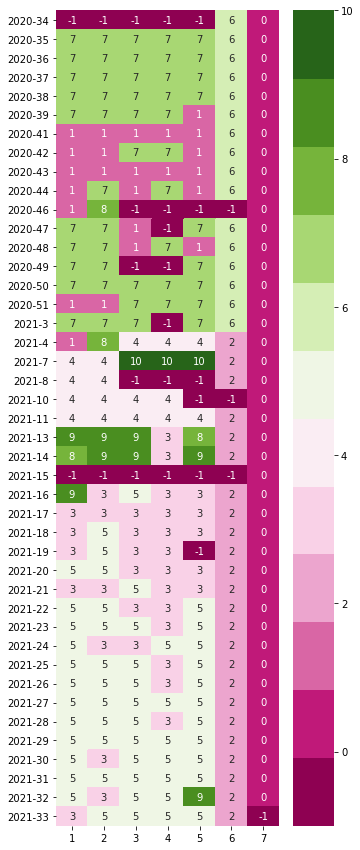

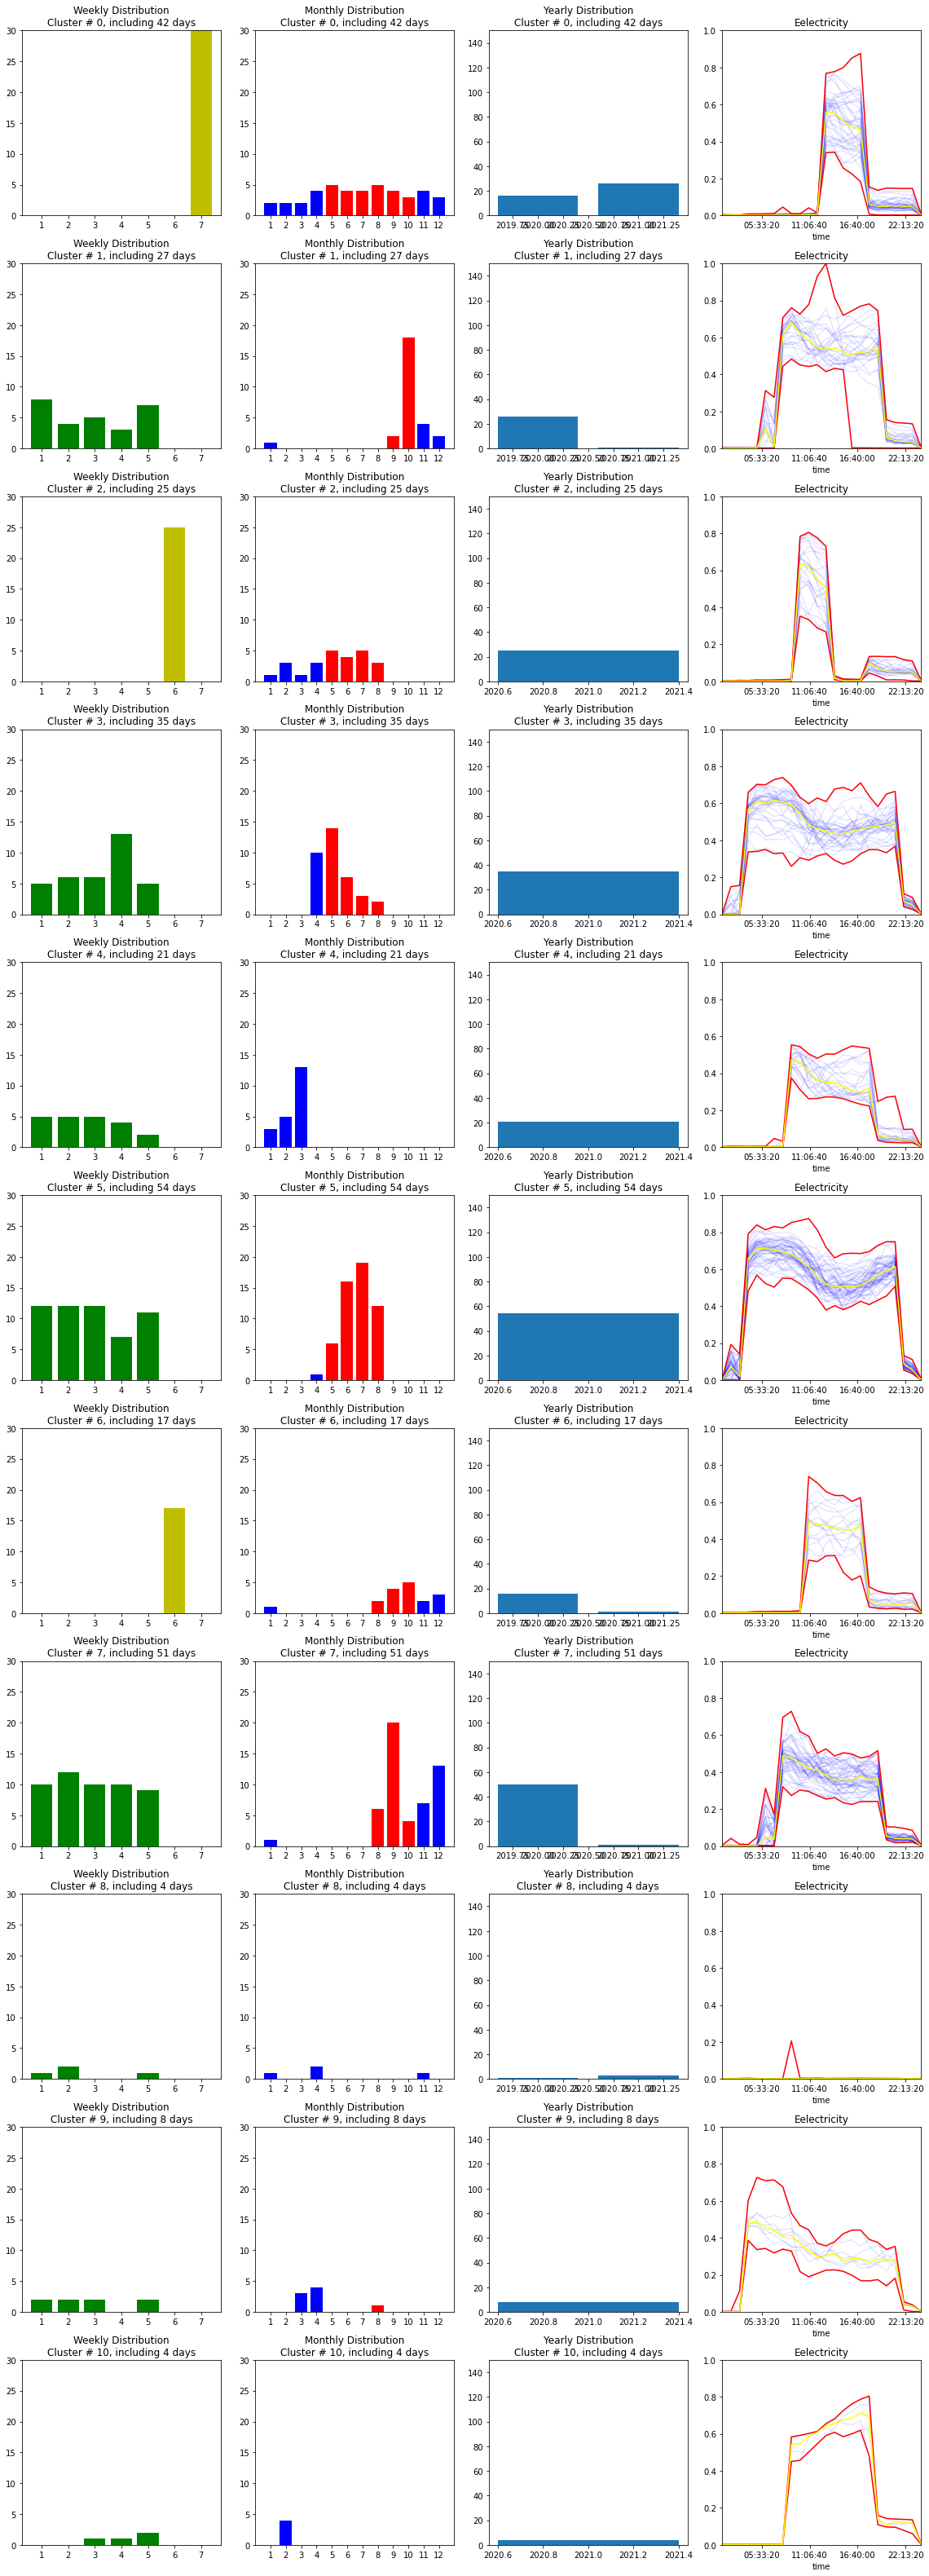

In [15]:
dataset = np.array(dataset)
n_row = 4
for cluster_name, obj in clusters.items(): 
    using_sklearn = obj["sklearn"]
    km = obj["model"]
    

    if using_sklearn:
        label = km.fit_predict(ts_dataset.squeeze())
    else: 
        km.fit(ts_dataset)
        label = km.predict(ts_dataset)
    # Graph: Class heatmap
    fig = get_cluster_heatmap(label, time)
    fig.savefig(getimgname(cluster_name, n_clusters, "heatmap"), dpi=100)
    
    fig, axs = plt.subplots(n_clusters, n_row, figsize=(4 * n_row, 4 * n_clusters))
    # fig, axs = plt.subplots(n_clusters, 5, figsize=(20, 4 * n_clusters))
    color_week= ['g', 'g', 'g', 'g', 'g', 'y', 'y']
    color_month= ['b','b','b','b','r','r','r','r','r','r','b','b']
    ylim = np.max(dataset)
    for cluster_no in range(n_clusters):
        index_list = numpy.where(label==cluster_no)[0].tolist()
        weekday = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
        month = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
        year = {}
        for index in index_list:
            if time[index].year not in year:
                year[time[index].year] = 0
            year[time[index].year] += 1
            weekday[time[index].weekday()] += 1
            month[time[index].month - 1] += 1
        indexes = numpy.where(label==cluster_no)[0].tolist()
        draw_multiple_timelines(dataset[:, 0:24], timestamp, indexes, axs[cluster_no][3], ylim, title="Eelectricity")
        if (n_row == 5):
            draw_multiple_timelines(dataset[:, 24:48], timestamp_temperature, indexes, axs[cluster_no][4], ylim, title="Temperature")
        if (n_row == 6):
            draw_multiple_timelines(dataset[:, 48:], timestamp_humid, indexes, axs[cluster_no][5], ylim, title="Humid")
        # if not using_sklearn:
        #     df = pandas.DataFrame({'time': timestamp[0], 'value': km.cluster_centers_[cluster_no].reshape(-1)})
        #     df["time"] = pandas.to_timedelta(df["time"])
        #     df.plot.line(x="time", y="value", ax=axs[cluster_no][4], color="red", alpha=1, legend=False, ylim=(0, 20.0))
        # plt.subplot(n_clusters, 5, cluster_no * 5 + 1)
        plt.subplot(n_clusters, n_row, cluster_no * n_row + 1)
        plt.bar([str(x + 1) for x in weekday.keys()], weekday.values(), color=color_week)
        plt.ylim(0, 30)
        plt.title("Weekly Distribution\nCluster # {}, including {} days".format(cluster_no, sum(weekday.values())))
        # plt.subplot(n_clusters, 5, cluster_no * 5 + 2)
        plt.subplot(n_clusters, n_row, cluster_no * n_row + 2)
        plt.bar([str(x + 1) for x in month.keys()], month.values(), color=color_month)
        plt.ylim(0, 30)
        plt.title("Monthly Distribution\nCluster # {}, including {} days".format(cluster_no, sum(month.values())))
        # plt.subplot(n_clusters, 5, cluster_no * 5 + 3)
        plt.subplot(n_clusters, n_row, cluster_no * n_row + 3)
        plt.bar(year.keys(), year.values())    
        plt.ylim(0, 150)
        plt.title("Yearly Distribution\nCluster # {}, including {} days".format(cluster_no, sum(year.values())))
    
    plt.tight_layout()
    plt.savefig(getimgname(cluster_name, n_clusters,"distribution"), dpi=100)
    break

In [16]:


holidays = [
    datetime.datetime(2020, 1, 27), 
    datetime.datetime(2020, 3, 9), 
    datetime.datetime(2020, 4, 10), 
    datetime.datetime(2020, 4, 11), 
    datetime.datetime(2020, 4, 12), 
    datetime.datetime(2020, 4, 13), 
    datetime.datetime(2020, 4, 25), 
    datetime.datetime(2020, 6, 8), 
    datetime.datetime(2020, 10, 23), 
    datetime.datetime(2020, 11, 3), 
    datetime.datetime(2020, 12, 25), 
    datetime.datetime(2020, 12, 26), 
    datetime.datetime(2020, 12, 28),
    datetime.datetime(2021, 1, 1), 
    datetime.datetime(2021, 1, 26), 
    datetime.datetime(2021, 3, 28), 
    datetime.datetime(2021, 4, 2), 
    datetime.datetime(2021, 4, 3), 
    datetime.datetime(2021, 4, 4), 
    datetime.datetime(2021, 4, 5), 
    datetime.datetime(2021, 4, 25), 
    datetime.datetime(2021, 6, 14), 
    datetime.datetime(2021, 9, 24), 
    datetime.datetime(2021, 2, 11), 
    datetime.datetime(2021, 12, 25), 
    datetime.datetime(2021, 12, 26), 
    datetime.datetime(2021, 12, 28), 
]

def isholiday(time):
    for t in holidays:
        if t.year == time.year and t.month == time.month and t.day == time.day:
            return True
    return False

In [29]:
def get_supervised_training_set(label, time):
    features = []
    for i in range(len(time)):
        weekday = [0 for _ in range(7)]
        weekday[time[i].weekday() - 1] = 1
        month = [0 for _ in range(12)]
        month[time[i].month - 1] = 1
        feature = weekday + month + [isholiday(time[i])]
        features.append(feature)
    return features

In [30]:
supervised_X = np.array(get_supervised_training_set(label, time))
supervised_Y = np.array(label)

In [31]:
import random
import sklearn
import sklearn.metrics

In [32]:
index = [x for x in range(len(supervised_X))]
random.shuffle(index)

In [33]:
training_index = index[len(index) // 10:]
validation_index = index[:len(index) // 10]
training_X = supervised_X[training_index]
training_Y = supervised_Y[training_index]
validation_X = supervised_X[validation_index]
validation_Y = supervised_Y[validation_index]

In [34]:
classifier = sklearn.tree.DecisionTreeClassifier()
classifier.fit(training_X, training_Y)
y_predit = classifier.predict(validation_X)
report = sklearn.metrics.classification_report(validation_Y, y_predit, output_dict = True)

In [38]:
print(report)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5}, '3': {'precision': 0.8, 'recall': 0.6666666666666666, 'f1-score': 0.7272727272727272, 'support': 6}, '4': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.888888888888889, 'support': 4}, '5': {'precision': 0.6, 'recall': 0.75, 'f1-score': 0.6666666666666665, 'support': 4}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.8571428571428571, 'macro avg': {'precision': 0.7999999999999999, 'recall': 0.824074074074074, 'f1-score': 0.8092031425364757, 'support': 28}, 'weighted avg': {'precision': 0.8357142857142856, 'recall': 0.8571428571428571, 'f1-score': 0.8423520923520923, 'support': 28}}


In [53]:
t = []
for i in range(n_clusters):
    lower, median, upper = get_bound(dataset, numpy.where(label==i)[0].tolist())
    df = pandas.DataFrame(
        {
            "Time Stamp": timestamp[0], 
            "median": median, 
            "lower": lower, 
            "upper": upper
        }
    )
    t.append(df)

In [76]:
def abnormal_detection(time, val, curve_df):
    test = curve_df.copy()
    test.loc[test.index.size] = [timestamp[0][0], None, None, None]
    test = test.sort_values('Time Stamp')
    test["median"] = test["median"].interpolate(method='linear')
    test["lower"] = test["lower"].interpolate(method='linear')
    test["upper"] = test["upper"].interpolate(method='linear')
    interpolated = test[test["Time Stamp"] == time]
    
    median = interpolated["median"][0]
    upper = interpolated["upper"][0]
    lower = interpolated["lower"][0]
    
    larger_than_median = val > median
    abnormal = val >= upper or val <= lower
    return larger_than_median, abnormal

In [77]:
abnormal_detection(timestamp[0][0], 0.01, t[0])

(True, True)